# Context
This dataset contains 4242 real images of flowers.
The data collection is based on the data flicr, google images, yandex images.
We can use this datastet to recognize plants from the photo.

Content
:The pictures are divided into five classes: [Daisy, tulip, rose, sunflower, dandelion.]

:For each class there are about 800 photos. Photos are not high resolution, about 320x240 pixels. Photos are not reduced to a single size, they have different proportions!

### Importing Libraries

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

### Downloading dataset from kaggle

In [2]:
!pip install opendatasets --upgrade --quiet
import opendatasets as od
path='https://www.kaggle.com/alxmamaev/flowers-recognition'
od.download(path)

  1%|          | 5.00M/450M [00:00<00:15, 30.5MB/s]

100%|██████████| 450M/450M [00:04<00:00, 99.5MB/s]


### Loading in Directory

In [3]:
import os
data_dir='/content/flowers-recognition/flowers/flowers'
os.listdir(data_dir)
Dict={0:'Daisy',1:'Dandelion',2:'Tulip',3:'sunflower',4:'Rose'}

#### Extracting Train/Test Batchdata 

In [161]:
#batch_size=32
img_height=150
img_width=150
train= tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width))


Found 4323 files belonging to 5 classes.
Using 3459 files for training.


In [162]:
train # This data is Batchdataset with training image in 4D tensor(50,240,240,3) and image label(50,) 

<BatchDataset shapes: ((None, 150, 150, 3), (None,)), types: (tf.float32, tf.int32)>

In [163]:
test= tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width))
  

Found 4323 files belonging to 5 classes.
Using 864 files for validation.


## Converting BatachDataset into Numpy array and Splitting numpy array into features and labels 

In [164]:
def split_dataset(Data,total_batch,Shape):
  xtrain=[]
  ytrain=[]
  for i,j in Data.take(total_batch):
       xtrain.append(i)
       ytrain.append(j)
  xtrain=np.array(xtrain)
  ytrain=np.array(ytrain)
  xtrain=xtrain.reshape(int(xtrain.shape[0]*xtrain.shape[1]),Shape[0],Shape[1],3)
  ytrain=ytrain.reshape(int(ytrain.shape[0]*ytrain.shape[1]),1)
  return xtrain,ytrain

In [166]:
# Converted Tensorflow BatchDataset into Numpy array and splitted features and labels
training_batches=108
testing_batches=27
Shape=[150,150]
xtrain,ytrain=split_dataset(train,training_batches,Shape)
xtest,ytest=split_dataset(test,testing_batches,Shape)
print(xtrain.shape)
print(ytrain.shape)
print(xtest.shape)
print(ytest.shape)

(3456, 150, 150, 3)
(3456, 1)
(864, 150, 150, 3)
(864, 1)


## EDA:
###Plotting Random Flower Images

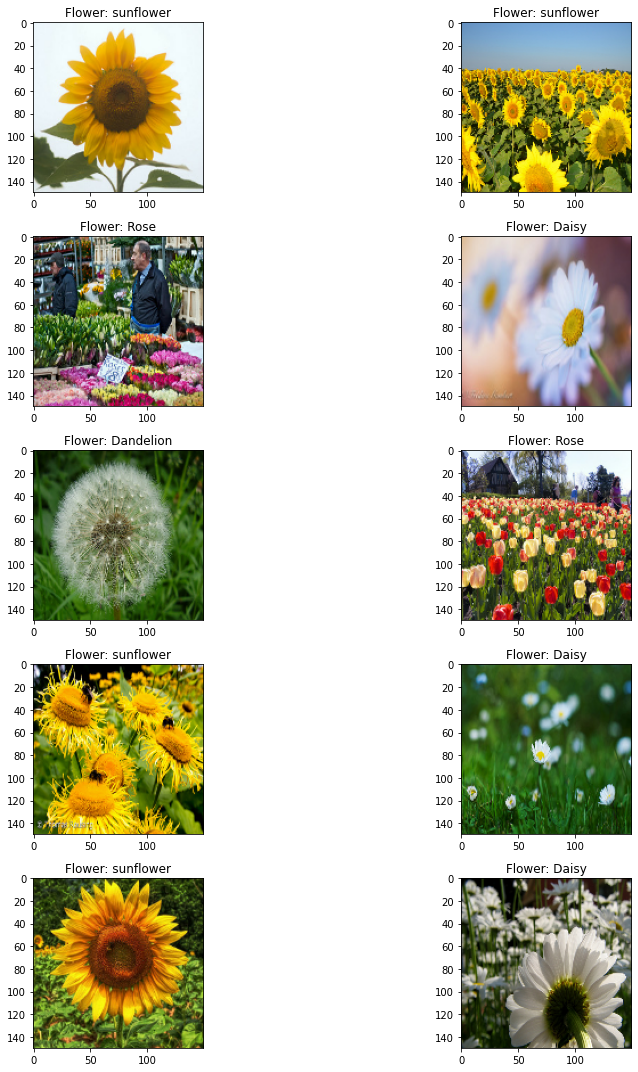

In [11]:
import random as rn
fig,ax=plt.subplots(5,2)
fig.set_size_inches(15,15)
for i in range(5):
    for j in range (2):
        l=rn.randint(0,len(xtrain))
        ax[i,j].imshow(xtrain[l].astype('uint8'))
        ax[i,j].set_title('Flower: '+Dict[int(ytrain[l])])

plt.tight_layout()
        

In [12]:
AUTOTUNE = tf.data.AUTOTUNE    # Let's make sure to use buffered prefetching so we can yield data from disk without having I/O become blocking
                               #These 2 cache(),prefetch() are important steps for smooth yield of data 
train= train.cache().prefetch(buffer_size=AUTOTUNE)
test = test.cache().prefetch(buffer_size=AUTOTUNE)

# :Modeling

### 1.1 ImageAugmentation_ Method(1)

In [13]:
from keras import layers
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.1),
  layers.experimental.preprocessing.RandomContrast(0.1),
  #layers.experimental.preprocessing.RandomCrop(0.1,0.2), 
  layers.experimental.preprocessing.RandomZoom(0.1,0.1,fill_mode='nearest'),
  layers.experimental.preprocessing.Resizing(180,180),
])

## 1.2 Image Augmentation using ImageDataGenerator_Method(2)

In [99]:
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(
        rescale=1./255,
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.2,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.2,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False)  # randomly flip images
test_datagen = ImageDataGenerator(rescale=1./255)       
train_generator = train_datagen.flow(xtrain,batch_size=32)

### 2. Setting up callbacks for  
####    1.Learning Rate Annealer  2.EarlyStopping  3.Model_checkpoint for saving

In [138]:
from keras import callbacks
from keras.callbacks import ReduceLROnPlateau
# Callback for Learning rate change
red_lr= ReduceLROnPlateau(monitor='val_accuracy',patience=4,verbose=1,factor=0.1)

#callback for checkpoint save of best model
checkpoint_filepath = '/tmp/checkpoint'
model_checkpoint= tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

#callback for earlystopping to stop before overfitting
early_stopping=tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=8,
    verbose=0,
    mode="auto",
    baseline=None,
    restore_best_weights=False,
)
callback=[red_lr,model_checkpoint,early_stopping]

# Model1 :
## Without Image Augmentation/ LearningRate annealing /Regularisation

In [16]:
from keras import layers
num_classes = 5

model1= tf.keras.Sequential([
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(32, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, activation='relu'),
  layers.MaxPooling2D(),  
  layers.Conv2D(128, 3, activation='relu'),
  layers.MaxPooling2D(),   
  layers.Flatten(),
  layers.Dense(128, activation='relu'), 
  layers.Dense(64, activation='relu'),   
  layers.Dense(num_classes,activation='softmax')
])

## Fitting Model1 on BatchDataset(Train,test)object of tf.data.dataset 

In [ ]:
model1.compile(
  optimizer='adam',
  loss='SparseCategoricalCrossentropy',
  metrics=['accuracy'])

history=model1.fit( train,validation_data=test,epochs=50,callbacks=[early_stopping])   

Epoch 1/50
109/109 [==============================] - 11s 93ms/step - loss: 1.5346 - accuracy: 0.2847 - val_loss: 1.1238 - val_accuracy: 0.5150
Epoch 2/50
109/109 [==============================] - 10s 90ms/step - loss: 1.1728 - accuracy: 0.5071 - val_loss: 1.1042 - val_accuracy: 0.5150
Epoch 3/50
109/109 [==============================] - 10s 91ms/step - loss: 1.0301 - accuracy: 0.5651 - val_loss: 1.0010 - val_accuracy: 0.5509
Epoch 4/50
109/109 [==============================] - 10s 92ms/step - loss: 0.9655 - accuracy: 0.5971 - val_loss: 0.8568 - val_accuracy: 0.6528
Epoch 5/50
109/109 [==============================] - 10s 91ms/step - loss: 0.8593 - accuracy: 0.6524 - val_loss: 0.8091 - val_accuracy: 0.6701
Epoch 6/50
109/109 [==============================] - 10s 92ms/step - loss: 0.7850 - accuracy: 0.6918 - val_loss: 0.7876 - val_accuracy: 0.6863
Epoch 7/50
109/109 [==============================] - 10s 92ms/step - loss: 0.7577 - accuracy: 0.7182 - val_loss: 0.8299 - val_accuracy:

### We can see that every epoch takes 10sec to train 
##  Now we will Train Model1 on numpy array Data(xtrain,ytrain and xtest,ytest)

In [20]:
model1.compile(optimizer='Adam',loss='SparseCategoricalCrossentropy',metrics='accuracy')
batch_size=32
History1 = model1.fit(datagen.flow(xtrain,ytrain,batch_size=batch_size),
                              epochs = 50,validation_data=(xtest,ytest),
                              verbose = 1, ,callbacks=callback)

Epoch 1/50
108/108 [==============================] - 3s 20ms/step - loss: 0.8264 - accuracy: 0.6818 - val_loss: 0.7629 - val_accuracy: 0.6933
Epoch 2/50
108/108 [==============================] - 2s 19ms/step - loss: 0.6936 - accuracy: 0.7295 - val_loss: 0.7190 - val_accuracy: 0.7188
Epoch 3/50
108/108 [==============================] - 2s 18ms/step - loss: 0.6682 - accuracy: 0.7503 - val_loss: 0.7443 - val_accuracy: 0.7257
Epoch 4/50
108/108 [==============================] - 2s 18ms/step - loss: 0.6330 - accuracy: 0.7571 - val_loss: 0.7370 - val_accuracy: 0.7118
Epoch 5/50
108/108 [==============================] - 2s 18ms/step - loss: 0.5805 - accuracy: 0.7717 - val_loss: 0.7539 - val_accuracy: 0.7164
Epoch 6/50
108/108 [==============================] - 2s 19ms/step - loss: 0.5390 - accuracy: 0.7992 - val_loss: 0.7709 - val_accuracy: 0.7037
Epoch 7/50
108/108 [==============================] - 2s 19ms/step - loss: 0.4956 - accuracy: 0.8163 - val_loss: 0.7410 - val_accuracy: 0.7419

### Huge difference in Training Time as it takes only 2secs to train each epoch.....5X times faster on Numpy Data than Tensorflow Batch data 
# CONCLUSION: 
### Try to convert Any Image Data to proper Numpy array of 4D for training instead of using Batchdataset objects for Faster Training time

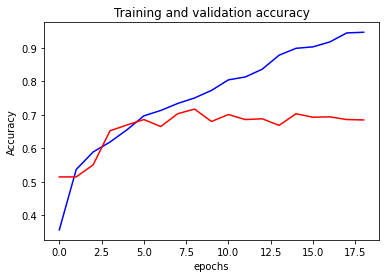

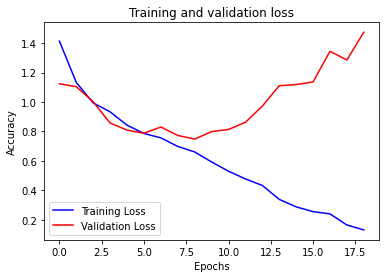

In [ ]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('epochs')
plt.ylabel('Accuracy')
plt.figure()

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

## Clear Overfitting is seen FOR MODEL1 , so now we will use all techniques like:

###  1. ImageAugmentation,
###  2. Learning rate annealer 
###  3. Regulisation Techniques like Dropout and L2 Weight regularisers

# **Model** **2**:

In [46]:
from tensorflow.keras import layers
from tensorflow.keras import regularizers
model2= tf.keras.Sequential([
  layers.experimental.preprocessing.Rescaling(1./255),
  data_augmentation,
  layers.Conv2D(32, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, activation='relu'),
  layers.Dropout(.2), 
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, activation='relu'),
  layers.Dropout(.2), 
  layers.MaxPooling2D(),  
  layers.Conv2D(128, 3, activation='relu'),
  layers.MaxPooling2D(),   
  layers.Flatten(),
  layers.Dropout(.5),  
  layers.Dense(512, activation='relu',kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4),
                    bias_regularizer=regularizers.l2(1e-4),
                    activity_regularizer=regularizers.l2(1e-5)),
  layers.Dropout(.5),   
  layers.Dense(128, activation='relu',    kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4),
                   bias_regularizer=regularizers.l2(1e-4),
                   activity_regularizer=regularizers.l2(1e-5)),   
  layers.Dense(num_classes,activation='softmax')
])

In [ ]:
optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3)
callback=[red_lr,model_checkpoint,early_stopping]
model2.compile(
  optimizer=optimizer,
  loss='SparseCategoricalCrossentropy',
  metrics=['accuracy'])

history2=model2.fit(train, validation_data=test,epochs=50, 
                    callbacks=callback)

Epoch 1/50
109/109 [==============================] - 12s 97ms/step - loss: 1.8194 - accuracy: 0.2866 - val_loss: 1.5135 - val_accuracy: 0.4167
Epoch 2/50
109/109 [==============================] - 11s 93ms/step - loss: 1.4598 - accuracy: 0.4399 - val_loss: 1.3483 - val_accuracy: 0.4792
Epoch 3/50
109/109 [==============================] - 11s 95ms/step - loss: 1.3230 - accuracy: 0.5193 - val_loss: 1.2300 - val_accuracy: 0.5544
Epoch 4/50
109/109 [==============================] - 10s 93ms/step - loss: 1.2776 - accuracy: 0.5376 - val_loss: 1.2261 - val_accuracy: 0.5567
Epoch 5/50
109/109 [==============================] - 10s 93ms/step - loss: 1.2281 - accuracy: 0.5581 - val_loss: 1.1242 - val_accuracy: 0.6273
Epoch 6/50
109/109 [==============================] - 10s 93ms/step - loss: 1.1466 - accuracy: 0.5887 - val_loss: 1.0959 - val_accuracy: 0.6435
Epoch 7/50
109/109 [==============================] - 11s 94ms/step - loss: 1.0905 - accuracy: 0.6170 - val_loss: 1.0155 - val_accuracy:

## Evaluating Model2 Performance

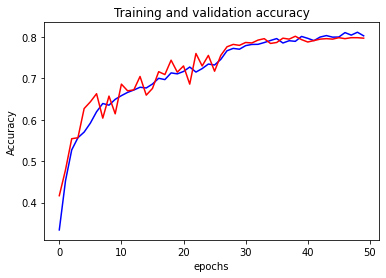

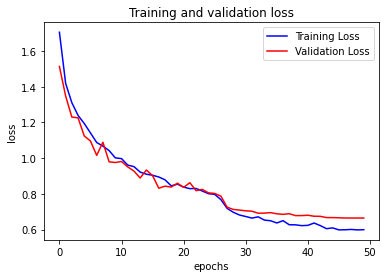

In [ ]:
import matplotlib.pyplot as plt
acc = history2.history['accuracy']
val_acc = history2.history['val_accuracy']
loss = history2.history['loss']
val_loss = history2.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('epochs')
plt.ylabel('Accuracy')

plt.figure()

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('loss')

plt.show()

### Much Better model with no overfitting now with Training and validation accuracy converging to 80%

# Prediction on Test Images

In [98]:
for x,y in test.take(2):
  x_test=x
  y_test=y
  break
x_test=np.array(x_test)
ypred=model2.predict(x_test)

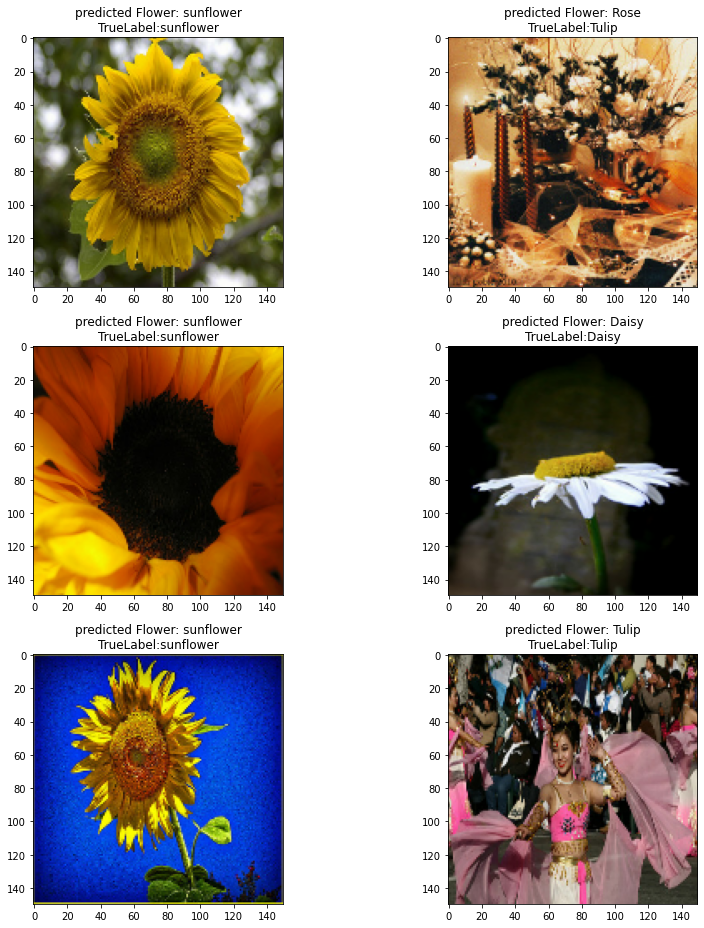

In [97]:
y_pred_digits=np.argmax(ypred,axis=1)
y_pred_digits
import random as rn
fig,ax=plt.subplots(3,2)
fig.set_size_inches(13,13)
for i in range(3):
    for j in range (2):
        l=rn.randint(0,len(x_test))
        ax[i,j].imshow(x_test[l].astype('uint8'))
        ax[i,j].set_title('predicted Flower: '+str(Dict[int(y_pred_digits[l])])+'\n'+'TrueLabel:'+str(Dict[int(y_test[l])]))
        

plt.tight_layout()

### Conclusion: Model gets confused mostly between TULIP and ROSE as both looks same

# Using Pretrained Models

##           1.RESNET50 MODEL:

In [54]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
path ='../input/resnet50/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5'
pre_trained_model=ResNet50(include_top=False, pooling='avg', weights=None)
#pre_trained_model.summary()

In [56]:
from tensorflow import keras
from keras import layers
from keras import regularizers
num_classes=5
model3 = tf.keras.Sequential()
model3.add(ResNet50(include_top=False, pooling='avg', weights=None))
model3.add(layers.Flatten())
model3.add(layers.Dropout(0.5))
model3.add(layers.Dense(512, activation='relu',kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4),
                                               bias_regularizer=regularizers.l2(1e-4),
                                               activity_regularizer=regularizers.l2(1e-5)))
model3.add(layers.Dropout(0.5))
model3.add(layers.Dense(128, activation='relu',kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4),
                                                 bias_regularizer=regularizers.l2(1e-4),
                                                 activity_regularizer=regularizers.l2(1e-5)))
model3.add(layers.Dense(num_classes, activation='softmax'))
model3.layers[0].trainable = False
model3.summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 2048)              23587712  
_________________________________________________________________
flatten_13 (Flatten)         (None, 2048)              0         
_________________________________________________________________
dropout_50 (Dropout)         (None, 2048)              0         
_________________________________________________________________
dense_39 (Dense)             (None, 512)               1049088   
_________________________________________________________________
dropout_51 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_40 (Dense)             (None, 128)               65664     
_________________________________________________________________
dense_41 (Dense)             (None, 5)               

In [175]:
optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3)
callback=[red_lr,model_checkpoint,early_stopping]
model3.compile(
  optimizer=optimizer,
  loss='SparseCategoricalCrossentropy',
  metrics=['accuracy'])

history3=model3.fit(xtrain,ytrain, validation_data=(xtest,ytest),epochs=10, 
                    callbacks=callback)

Epoch 1/10
108/108 [==============================] - 11s 75ms/step - loss: 1.6349 - accuracy: 0.2457 - val_loss: 1.6059 - val_accuracy: 0.2442
Epoch 2/10
108/108 [==============================] - 7s 67ms/step - loss: 1.6144 - accuracy: 0.2590 - val_loss: 1.6193 - val_accuracy: 0.2326
Epoch 3/10
108/108 [==============================] - 7s 67ms/step - loss: 1.6193 - accuracy: 0.2394 - val_loss: 1.6025 - val_accuracy: 0.3032
Epoch 4/10
108/108 [==============================] - 7s 68ms/step - loss: 1.6094 - accuracy: 0.2840 - val_loss: 1.6059 - val_accuracy: 0.2535
Epoch 5/10
108/108 [==============================] - 7s 68ms/step - loss: 1.6077 - accuracy: 0.2627 - val_loss: 1.5714 - val_accuracy: 0.2998
Epoch 6/10
108/108 [==============================] - 7s 68ms/step - loss: 1.5992 - accuracy: 0.2731 - val_loss: 1.5460 - val_accuracy: 0.3495
Epoch 7/10
108/108 [==============================] - 7s 67ms/step - loss: 1.5982 - accuracy: 0.2754 - val_loss: 1.5968 - val_accuracy: 0.278

## Conclusion: 
###Resnet50 didnt perform well with all layers freezed, we need to unfreeze more layers from base model to learn more parameters from this dataset for better performance

## 2.INCEPTIONV3 MODEL

In [101]:
import os
from tensorflow.keras import layers
from tensorflow.keras import Model
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
  
from tensorflow.keras.applications.inception_v3 import InceptionV3

local_weights_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

pre_trained_model = InceptionV3(input_shape = (150, 150, 3), 
                                include_top = False, 
                                weights = None)

pre_trained_model.load_weights(local_weights_file)
# used for freezing
for layer in pre_trained_model.layers:
  layer.trainable = False
  

#pre_trained_model.summary()

last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

--2021-03-01 07:18:26--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.142.128, 74.125.195.128, 74.125.20.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.142.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/tmp/inception_v3_w 100%[===================>]  83.84M   160MB/s    in 0.5s    

2021-03-01 07:18:27 (160 MB/s) - ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]

last layer output shape:  (None, 7, 7, 768)


In [135]:
from tensorflow.keras.optimizers import RMSprop

# Flatten the output layer to 1 dimension

x = layers.Flatten()(last_output)
x = layers.Dropout(0.5)(x)  
x = layers.Dense(512, activation='relu')(x)
x = layers.Dropout(0.5)(x)      
x = layers.Dense(128, activation='relu')(x)            
x = layers.Dense  (5, activation='softmax')(x)           

model_inc = Model( pre_trained_model.input, x) 

model_inc.compile(optimizer = RMSprop(lr=0.001), 
              loss = 'SparseCategoricalCrossentropy', 
              metrics = ['accuracy'])


In [140]:
history_inc=model_inc.fit(train,validation_data=(test),epochs=50,callbacks=callback)

Epoch 1/50
109/109 [==============================] - 4s 39ms/step - loss: 1.4924 - accuracy: 0.3594 - val_loss: 1.4284 - val_accuracy: 0.4097
Epoch 2/50
109/109 [==============================] - 4s 38ms/step - loss: 1.4617 - accuracy: 0.3559 - val_loss: 1.4269 - val_accuracy: 0.4086
Epoch 3/50
109/109 [==============================] - 4s 38ms/step - loss: 1.4725 - accuracy: 0.3646 - val_loss: 1.4218 - val_accuracy: 0.4086
Epoch 4/50
109/109 [==============================] - 4s 38ms/step - loss: 1.5005 - accuracy: 0.3588 - val_loss: 1.4291 - val_accuracy: 0.4178
Epoch 5/50
109/109 [==============================] - 4s 38ms/step - loss: 1.4770 - accuracy: 0.3686 - val_loss: 1.4304 - val_accuracy: 0.4120
Epoch 6/50
109/109 [==============================] - 4s 38ms/step - loss: 1.4885 - accuracy: 0.3614 - val_loss: 1.4274 - val_accuracy: 0.4155
Epoch 7/50
109/109 [==============================] - 4s 39ms/step - loss: 1.4837 - accuracy: 0.3654 - val_loss: 1.4260 - val_accuracy: 0.4120

## Conclusion: InceptionV3 Didnt perform well , we need to unfreeze more layers of base model to learn more parameters on this dataset for better performance

# 3.VGG16 MODEL

In [114]:
#batch_size=32
img_height=224
img_width=224
train2= tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width))
test2= tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width))
  

Found 4323 files belonging to 5 classes.
Using 3459 files for training.
Found 4323 files belonging to 5 classes.
Using 864 files for validation.


In [118]:
from tensorflow.keras.applications.vgg16 import VGG16

base_model = VGG16(input_shape = (224,224, 3), # Shape of our images
include_top = False, # Leave out the last fully connected layer
weights = 'imagenet')

In [167]:
for layer in base_model.layers:
    layer.trainable = False

x = layers.Flatten()(base_model.output)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(5, activation='softmax')(x)

model_vgg = tf.keras.models.Model(base_model.input, x)

model_vgg.compile(optimizer = tf.keras.optimizers.RMSprop(lr=0.0001), loss = 'SparseCategoricalCrossentropy',metrics = ['accuracy'])


In [169]:
history_vgg=model_vgg.fit(train2,validation_data=test2,epochs=15,callbacks=callback)

Epoch 1/15
109/109 [==============================] - 24s 219ms/step - loss: 0.6903 - accuracy: 0.8239 - val_loss: 1.0196 - val_accuracy: 0.7685
Epoch 2/15
109/109 [==============================] - 24s 217ms/step - loss: 0.4782 - accuracy: 0.8716 - val_loss: 1.0831 - val_accuracy: 0.7928
Epoch 3/15
109/109 [==============================] - 24s 218ms/step - loss: 0.3472 - accuracy: 0.9055 - val_loss: 1.2321 - val_accuracy: 0.8148
Epoch 4/15
109/109 [==============================] - 24s 219ms/step - loss: 0.3121 - accuracy: 0.9211 - val_loss: 1.3138 - val_accuracy: 0.8137
Epoch 5/15
109/109 [==============================] - 24s 219ms/step - loss: 0.2691 - accuracy: 0.9373 - val_loss: 1.3500 - val_accuracy: 0.8183
Epoch 6/15
109/109 [==============================] - 24s 220ms/step - loss: 0.2189 - accuracy: 0.9433 - val_loss: 1.4953 - val_accuracy: 0.8287
Epoch 7/15
109/109 [==============================] - 24s 220ms/step - loss: 0.2170 - accuracy: 0.9549 - val_loss: 1.5933 - val_ac

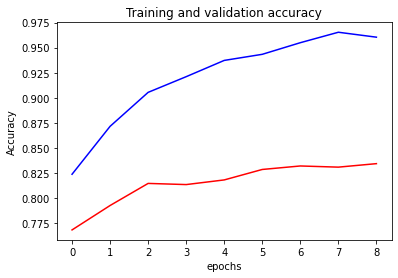

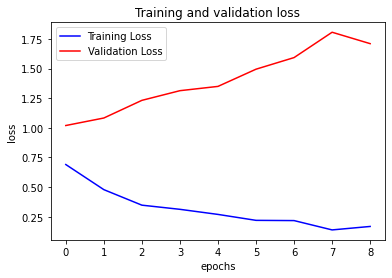

In [170]:
import matplotlib.pyplot as plt
acc = history_vgg.history['accuracy']
val_acc = history_vgg.history['val_accuracy']
loss = history_vgg.history['loss']
val_loss = history_vgg.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('epochs')
plt.ylabel('Accuracy')

plt.figure()

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('loss')

plt.show()

# Conclusion:
## Compared to Resnet50 and InceptionV3 VGG16 model quickly overfitted but it still gave better val_accurcy=83.4% on our dataset ,better than our own built model2 which gave till 80%

### Trying Tweaking hyperparameters can give better results on pretrained models